# Second Partial Exam GLM

@roman avj

April 27, 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pymc as pm
import arviz as az
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---
# Q1: Tenis Data
The following table shows the sample size $n_i$ and the average service time $\bar{y}_i$ (in seconds) for six professional tennis players. Suppose that the sample mean for player $i$ and $\bar{y}_i$ is normally distributed with mean $\mu_i$ and standard deviation $\sigma/\sqrt{n_i}$ where $\sigma = 5.5$ seconds.


In [2]:
# Load the data
df_tenis_players = pd.DataFrame({
    'Player': ['Murray', 'Simon', 'Federer', 'Ferrer', 'Isner', 'Kyrgios'],
    'n': [731, 570, 491, 456, 403, 274],
    'y': [23.56, 18.07, 16.21, 21.7, 22.31, 14.11]
}).set_index('Player')

df_tenis_players

,n,y
Player,,
Murray,731,23.56
Simon,570,18.07
Federer,491,16.21
Ferrer,456,21.70
Isner,403,22.31
Kyrgios,274,14.11


## Q1.A: Murray's average service time
Is of interest to estimate the average service time of Murray $\mu_1$. Find the posterior distribution of $\mu_1$ and construct a 90% credible interval for $\mu_1$.

In [3]:
# model
with pm.Model() as model:
    # priors
    mu = pm.Normal('mu_murray', mu=20, sigma=10)
    sigma = pm.ConstantData('sigma_murray', 5.5)
    n_obs = pm.ConstantData('n_obs', df_tenis_players.loc['Murray', 'n'])
    
    # likelihood
    likelihood = pm.Normal(
        'y',
        mu=mu,
        sigma=sigma / pm.math.sqrt(n_obs),
        observed=df_tenis_players.loc['Murray', 'y']
        )
    
    # sample
    trace = pm.sample(1000, tune=1000, cores=1, chains=4)
    trace = pm.sample_posterior_predictive(
        trace, extend_inferencedata=True, random_seed=42
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_murray]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


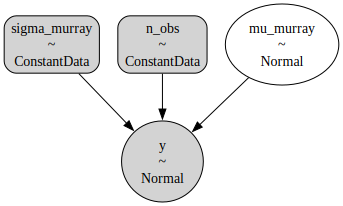

In [4]:
# look causal graph
pm.model_to_graphviz(model)

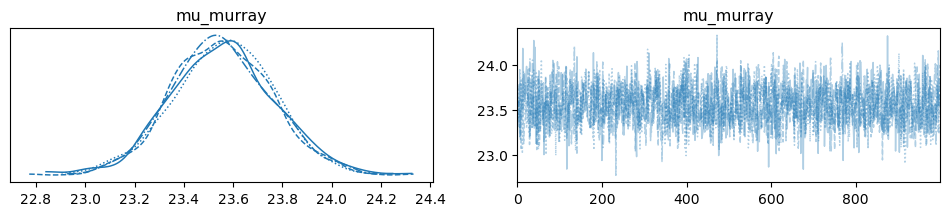

In [5]:
# posterior predictive check
az.plot_trace(trace, var_names=["mu_murray"])
plt.show()

In [6]:
# summary of the trace
az.summary(trace,  var_names=["mu_murray"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_murray,23.556,0.206,23.227,23.888,0.005,0.003,1733.0,2935.0,1.0


In [7]:
# interval length
23.886-23.222

0.6639999999999979

<Axes: title={'center': 'mu_murray'}>

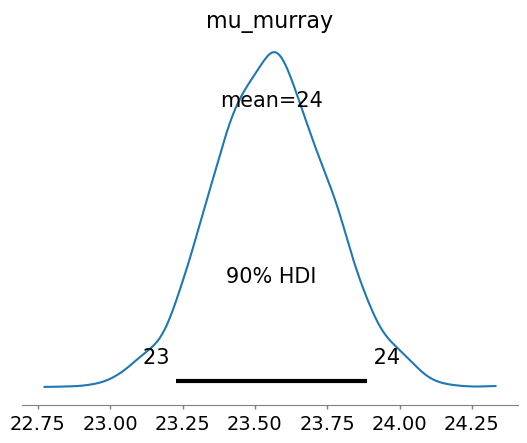

In [8]:
# plot posterior distribution for coefficients
az.plot_posterior(trace, var_names=["mu_murray"], hdi_prob=0.9)

## Q1.B: General model for all players
Assume that the average service time for all players is the same, $\mu_1 = \dots = \mu_6 = \mu$. The average service time for each player is $\bar{y} = 19.9$ with a combined sample size of $n = 2925$. Suppose that $\mu$ has an initial distribution $N(20, 10)$. Find the posterior distribution of $\mu$ and construct a 90% credible interval for $\mu$.



In [9]:
# get average time of players
avg_all_players_time = np.sum(df_tenis_players['y'] * df_tenis_players['n']) / np.sum(df_tenis_players['n'])
n_obs_all_players = np.sum(df_tenis_players['n'])

print(f"Average time of all players: {avg_all_players_time:.2f}")
print(f"Number of observations of all players: {n_obs_all_players}")

Average time of all players: 19.91
Number of observations of all players: 2925


In [10]:
# model
with pm.Model() as model:
    # priors
    mu = pm.Normal('mu_players', mu=20, sigma=10)
    sigma = pm.ConstantData('sigma_players', 5.5)
    n_obs = pm.ConstantData('n_obs', n_obs_all_players)
    
    # likelihood
    likelihood = pm.Normal(
        'y',
        mu=mu,
        sigma=sigma / pm.math.sqrt(n_obs),
        observed=avg_all_players_time
        )
    
    # sample
    trace = pm.sample(1000, tune=1000, cores=1, chains=4)
    trace = pm.sample_posterior_predictive(
        trace, extend_inferencedata=True, random_seed=42
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_players]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


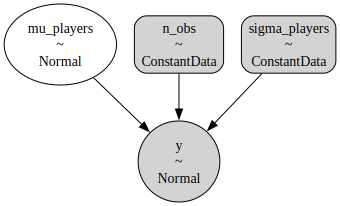

In [11]:
# look causal graph
pm.model_to_graphviz(model)

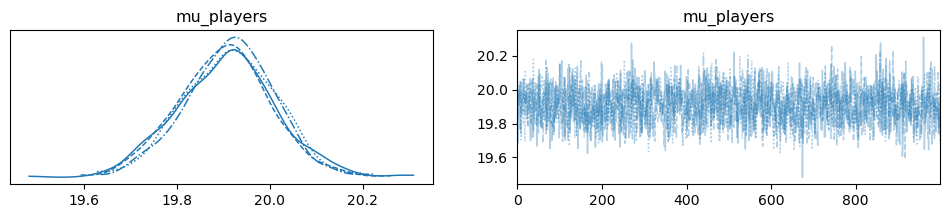

In [12]:
# posterior predictive check
az.plot_trace(trace, var_names=["mu_players"])
plt.show()

In [13]:
# summary of the trace
az.summary(trace,  var_names=["mu_players"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_players,19.909,0.1,19.742,20.07,0.002,0.002,1694.0,2868.0,1.0


<Axes: title={'center': 'mu_players'}>

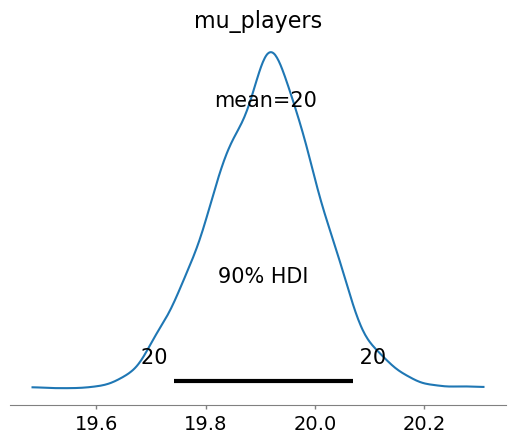

In [14]:
# plot posterior distribution for coefficients
az.plot_posterior(trace, var_names=["mu_players"], hdi_prob=0.9)

## Q1.C: Statement
Which approach, part (a) or part (b), seems more reasonable in this situation?


In my humble opinion, depends on what you want to know. If you want to know the average time of all players, you can use the average time of all players as the observed value. If you want to know the average time of a specific player (b), you can use the observed value of that player (a).

---
# Q2: Hierarchical model
Continuing with the previous problem, suppose that you want to estimate the average service time for the six tennis players using a hierarchical model. Recall that $\sigma = 5.5$ seconds.

$$
\bar{y}_i \sim N(\mu_i, \sigma/\sqrt{n_i}), \quad i=1,\dots,6 \\
\mu_i \sim N(\mu, \tau), \quad i=1,\dots,6 \\
\mu \sim N(20, 1/0.0001), \quad 1/\tau^2 \sim G(0.01, 0.1)
$$



## Q2.A: Posterior Distribution
Use pyMC, Stan or JAGS to simulate a sample of size 1000 from the posterior distribution of the hierarchical model

In [ ]:
# model
with pm.Model(coords={"obs_id": df_tenis_players.index}) as model:
    # data
    n_obs = pm.ConstantData('n_obs', df_tenis_players['n'], dims='obs_id')
    sigma = pm.ConstantData('sigma', 5.5)

    # priors
    general_mu = pm.Normal('general_mu', mu=20, tau=1e-4)  # general mu for all players
    inv_squared_tau = pm.Gamma('inv_squared_tau', alpha=1e-2, beta=1e-1)
    tau = 1 / pm.math.sqrt(inv_squared_tau)
    mu = pm.Normal('mu', mu=general_mu, tau=tau, dims='obs_id')

    # likelihood
    likelihood = pm.Normal(
        'y',
        mu=mu,
        sigma=sigma / pm.math.sqrt(n_obs),
        dims='obs_id',
        observed=df_tenis_players['y']
        )

    # sample
    trace = pm.sample(1000, tune=1000, cores=1, chains=4)
    trace = pm.sample_posterior_predictive(
        trace, extend_inferencedata=True, random_seed=42
        )


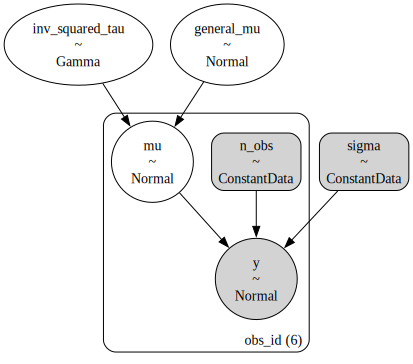

In [37]:
# look causal graph
pm.model_to_graphviz(model)

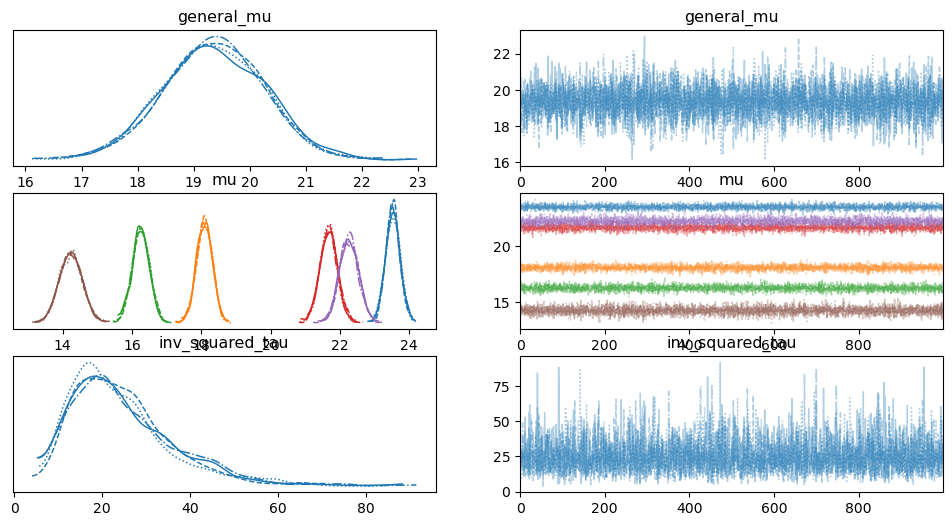

In [38]:
# posterior predictive check
az.plot_trace(trace)
plt.show()

## Q2.B: Build Credibility Intervals for the average time of each player

In [39]:
# get traze of each player average time
az.summary(trace, var_names=["mu"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Murray],23.526,0.207,23.197,23.880,0.003,0.002,5730.0,3302.0,1.0
mu[Simon],18.088,0.227,17.725,18.464,0.003,0.002,4605.0,3592.0,1.0
mu[Federer],16.253,0.244,15.853,16.663,0.004,0.003,4416.0,3075.0,1.0
mu[Ferrer],21.674,0.249,21.263,22.083,0.003,0.002,5529.0,3148.0,1.0
mu[Isner],22.262,0.273,21.821,22.706,0.004,0.003,4798.0,3222.0,1.0
mu[Kyrgios],14.233,0.329,13.723,14.796,0.005,0.003,4814.0,3240.0,1.0


In [18]:
# plot mean estimates with its HDP for each player
df_player_means = trace.posterior['mu'].mean(dim=['chain', 'draw']).to_dataframe().reset_index()
df_players_hdi = az.hdi(trace.posterior['mu'], hdi_prob=0.9).to_dataframe().reset_index().pivot(index='obs_id', columns='hdi', values='mu')

# join
df_player_means_data = df_player_means.merge(df_players_hdi, on='obs_id').sort_values('mu')
df_player_means_data


,obs_id,mu,higher,lower
5,Kyrgios,14.234793,14.758143,13.678383
2,Federer,16.251049,16.639012,15.822782
1,Simon,18.078536,18.460977,17.716452
3,Ferrer,21.659273,22.097509,21.239058
4,Isner,22.268682,22.709749,21.830758
0,Murray,23.523538,23.858120,23.182120


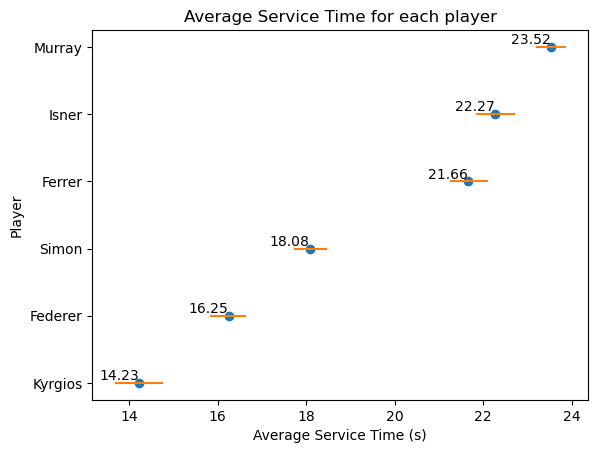

In [19]:
# plot service time
fig, ax = plt.subplots()

# lines for HDP
ax.hlines(
    y=df_player_means_data['obs_id'],
    xmin=df_player_means_data['lower'],
    xmax=df_player_means_data['higher'],
    color='C1', label='HDP'
    )

# scatter on mu
ax.scatter(df_player_means_data['mu'], df_player_means_data['obs_id'], label='Mean estimate')

# add time of all players above the point as text
for i, row in df_player_means_data.iterrows():
    ax.text(row['mu'], row['obs_id'], f"{row['mu']:.2f}", ha='right', va='bottom')

# plot
ax.set_xlabel('Average Service Time (s)')
ax.set_ylabel('Player')

# title
ax.set_title('Average Service Time for each player')

# show
plt.show()

## Q2.C: Compare Murray's service time

Compare the estimated average time of Murray using the hierarchical model with the results obtained in Q1.A.

In [20]:
# summary of the trace
az.summary(trace,  var_names=["mu"], coords={'obs_id': ['Murray']}, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Murray],23.524,0.207,23.182,23.858,0.003,0.002,4798.0,2815.0,1.0


In [21]:
# interval length
23.848-23.188

0.6600000000000001

<Axes: title={'center': 'mu\nMurray'}>

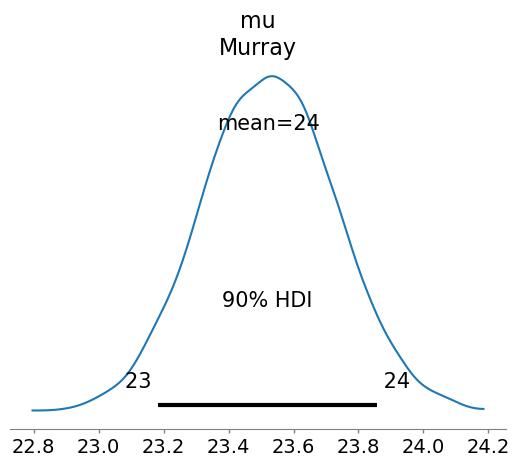

In [22]:
# plot posterior distribution for coefficients only for the mu with obs_id = Murray
az.plot_posterior(trace, var_names=["mu"], coords={'obs_id': ['Murray']}, hdi_prob=0.9)

The mean is slightly lower in the hierarchical model (2.a) than in the incomplete model (1.a). The HDI are similar, however the longitude of the hierarchical model (2.a) is slightly shorter, by only 0.003 seconds. 

---
# Q3: Fire Calls in Pennsylvania

The below displays the number of fire calls and the number of building fires for ten counties in Montgomery County, Pennsylvania from 2015 through 2019. This data is currently described as Emergency - 911 Calls” from  kaggle.com Suppose that the number of building fires for the $j$-th zip code is Poisson with mean $n_{j} \lambda_{j}$ , where $n_j$ and $\lambda_j$ are respectively the number of fire calls and rate of building fires for the $j$-th zip code.

In [23]:
# data
df_fire_calls = (
    pd.DataFrame({
        'zip_code': [18054, 18103, 19010, 19025, 19040, 19066, 19116, 19406, 19428, 19474],
        'fire_calls': [266, 1, 1470, 246, 1093, 435, 2, 2092, 2025, 4],
        'building_fires': [12, 0, 59, 11, 47, 26, 0, 113, 73, 1]
    })
    .set_index('zip_code')
    .assign(building_fire_rates=lambda x: x['building_fires'] / x['fire_calls'])
    .assign(
        building_fire_rates= lambda x: np.where(
            x['building_fire_rates'].eq(0), 0 + 1e-4, x['building_fire_rates']
        )
    )
)
df_fire_calls

,fire_calls,building_fires,building_fire_rates
zip_code,,,
18054,266,12,0.045113
18103,1,0,0.000100
19010,1470,59,0.040136
19025,246,11,0.044715
19040,1093,47,0.043001
19066,435,26,0.059770
19116,2,0,0.000100
19406,2092,113,0.054015
19428,2025,73,0.036049


## Q3.A: Posterior Distribution
Suppose that the building fire rates $\lambda_1, \ldots, \lambda_{10}$ follow a common Gamma($\alpha, \beta$) distribution where the hyperparameters $\alpha$ and $\beta$ follow weakly informative distributions. Use JAGS to simulate a sample of size 5000 from the joint posterior distribution of all parameters of the model.

In [93]:
{
        "obs_id": np.arange(df_fire_calls.shape[0]),
        "zip_code": df_fire_calls.index.values
        }

{'obs_id': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'zip_code': array([18054, 18103, 19010, 19025, 19040, 19066, 19116, 19406, 19428,
        19474])}

In [82]:
 # multilevel gamma poisson model
 with pm.Model(
    coords_mutable={
        "obs_id": np.arange(df_fire_calls.shape[0]),
        "zip_code": df_fire_calls.index.values
        }
    ) as model:
    # data
    fire_calls = pm.MutableData('fire_calls', df_fire_calls['fire_calls'].values, dims='obs_id')
    zip_code_idx = pm.MutableData('zip_code_idx', np.arange(df_fire_calls.shape[0]), dims='zip_code')

    # common priors
    alpha = pm.HalfNormal('alpha', sigma=10)
    beta = pm.HalfNormal('beta', sigma=10)
    mean_building_fire_rate = pm.Deterministic('mean_building_fire_rate', alpha / beta)

    # individual priors
    building_fire_rates = pm.Gamma('building_fire_rates', alpha, beta, dims='zip_code')
    building_fire_rates_per_zipcode = building_fire_rates[zip_code_idx]

    # likelihood
    likelihood = pm.Poisson(
        'building_fires',
        mu=building_fire_rates_per_zipcode * fire_calls,
        observed=df_fire_calls['building_fires'],
        dims='obs_id'
        )

    # sample
    trace = pm.sample(5000, tune=1000, cores=1, chains=4)
    trace = pm.sample_posterior_predictive(
        trace, extend_inferencedata=True, random_seed=42
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, beta, building_fire_rates]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 22 seconds.
Sampling: [building_fires]


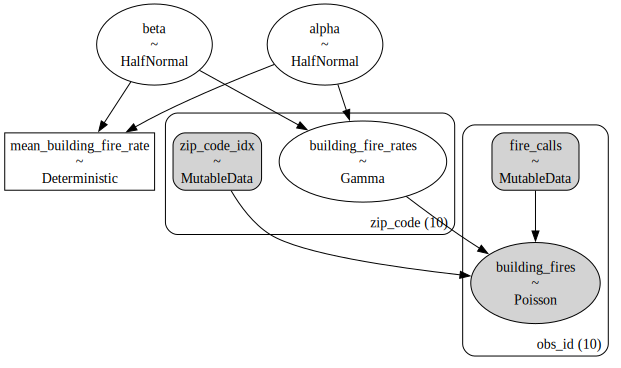

In [83]:
# look causal graph
pm.model_to_graphviz(model)

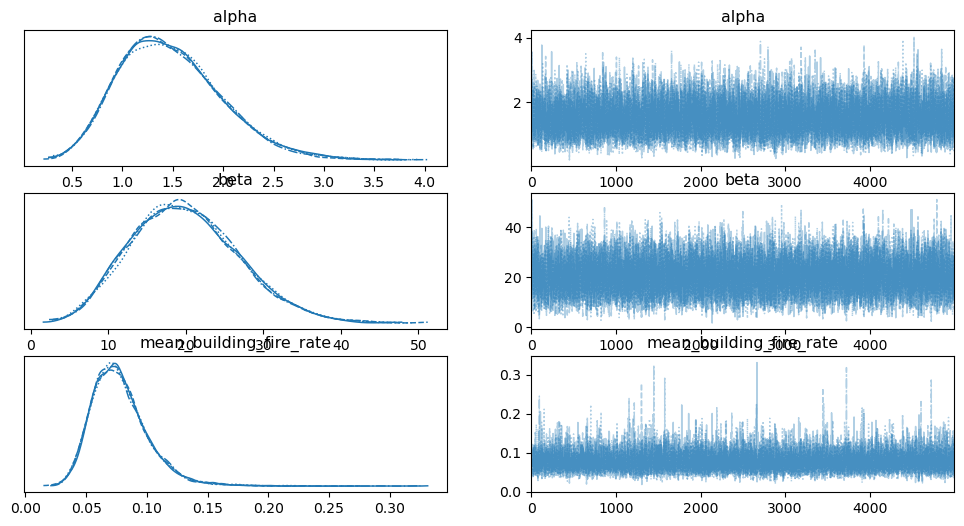

In [85]:
# posterior predictive check
az.plot_trace(trace, var_names=["alpha", "beta", "mean_building_fire_rate"])
plt.show()

In [86]:
# get building rates for each zip code
az.summary(trace, var_names=["mean_building_fire_rate", "building_fire_rates"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_building_fire_rate,0.078,0.024,0.042,0.114,0.000,0.0,20244.0,15728.0,1.0
building_fire_rates[18054],0.047,0.013,0.027,0.067,0.000,0.0,30722.0,14364.0,1.0
building_fire_rates[18103],0.074,0.068,0.000,0.159,0.000,0.0,15729.0,8523.0,1.0
building_fire_rates[19010],0.041,0.005,0.032,0.050,0.000,0.0,33315.0,13450.0,1.0
building_fire_rates[19025],0.047,0.013,0.025,0.068,0.000,0.0,27926.0,13838.0,1.0
building_fire_rates[19040],0.044,0.006,0.033,0.054,0.000,0.0,29956.0,15560.0,1.0
building_fire_rates[19066],0.060,0.012,0.041,0.079,0.000,0.0,28887.0,13629.0,1.0
building_fire_rates[19116],0.070,0.064,0.000,0.149,0.000,0.0,15259.0,7823.0,1.0
building_fire_rates[19406],0.054,0.005,0.046,0.063,0.000,0.0,31061.0,15160.0,1.0
building_fire_rates[19428],0.036,0.004,0.029,0.043,0.000,0.0,31356.0,13787.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='building_fires'>

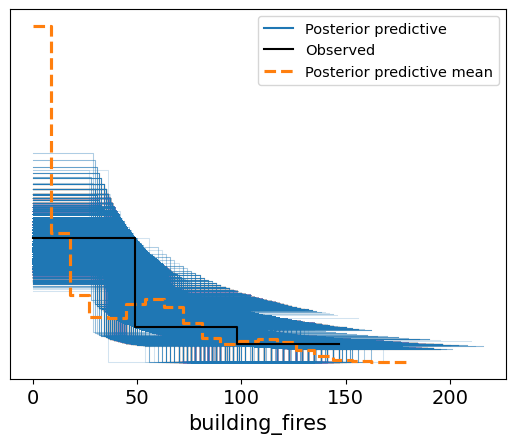

In [87]:
# plot posterior predictive for building fire rate
az.plot_ppc(trace)

## Q3.B: Individual Estimates
The individual estimates of the building rates for zip codes 18054 and 19010 are $12/266$ and $59/1470$, respectively. Contrast these estimates with the posterior means of the rates $\lambda_1$ and $\lambda_3$.

In [88]:
# summary of the trace
az.summary(trace,  var_names=["building_fire_rates"], coords={'zip_code': [18054, 19010]}, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
building_fire_rates[18054],0.047,0.013,0.027,0.067,0.0,0.0,30722.0,14364.0,1.0
building_fire_rates[19010],0.041,0.005,0.032,0.050,0.0,0.0,33315.0,13450.0,1.0


array([<Axes: title={'center': 'building_fire_rates\n18054'}>,
       <Axes: title={'center': 'building_fire_rates\n19010'}>],
      dtype=object)

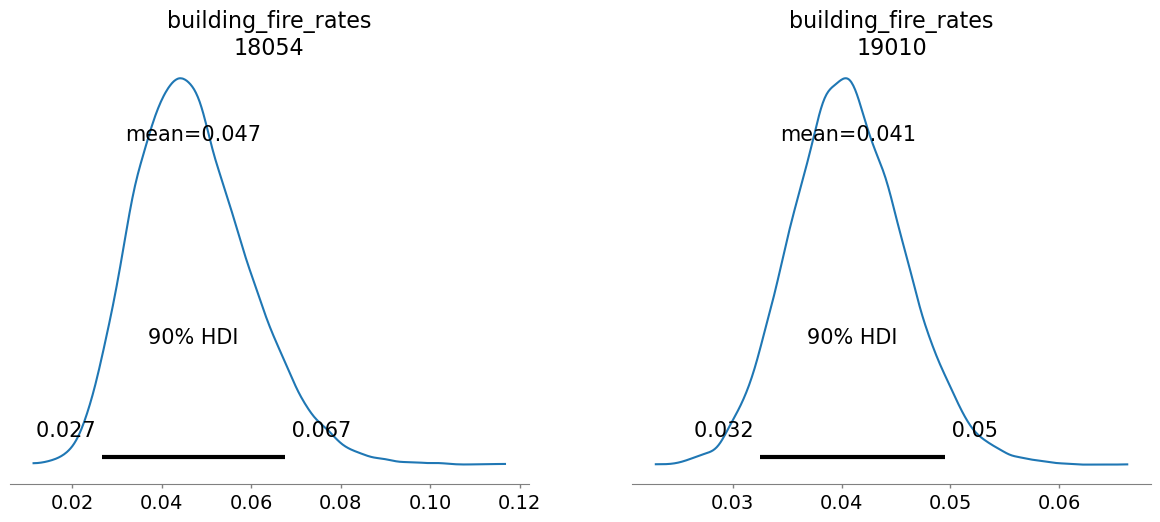

In [89]:
# plot posterior distribution for coefficients only for the mu with obs_id = Murray
az.plot_posterior(trace, var_names=["building_fire_rates"], coords={'zip_code': [18054, 19010]}, hdi_prob=0.9)

- The estimate rate for the zip code 18054 is 0.045 and the infered mean rate is 0.047. 
- The estimate rate for the zip code 19010 is 0.040 and the infered mean rate is 0.041.

For both cases, the estimated rate (frequency of building fires) is very close to the inferred mean rate.

## Q3.C: Mean Building Fire across all zip codes
The parameter $\mu = \alpha / \beta$ represents the mean building fire rates across zip codes. Construct a density estimate of the posterior distribution of $\mu$.

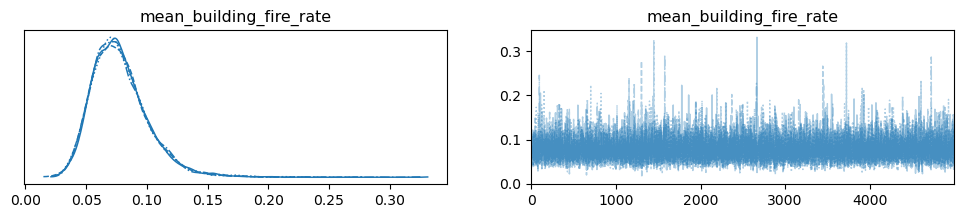

In [90]:
# posterior predictive check
az.plot_trace(trace, var_names=["mean_building_fire_rate"])
plt.show()

## Q3.D: Prediction for Zip Code 19066

Suppose that the county has 50 fire calls to the zip code 19066. Use the simulated predictive distribution to construct a 90% predictive interval for the number of building fires.

In [101]:
# predict new data
with model:
    # new data
    pm.set_data(
        new_data={
            "fire_calls": pd.Series(50),
            "zip_code_idx": pd.Series(
                df_fire_calls.index.get_loc(19066)
                )
            },
        coords={
            "obs_id": ['new_data'],
            "zip_code": ['new_data']
            }
        )

    # sample
    posterior_pred = pm.sample_posterior_predictive(
        trace,
        var_names=["building_fires"],
        predictions=True,
        random_seed=42
    )

Sampling: [building_fire_rates, building_fires]


IndexError: index 5 is out of bounds for axis 0 with size 1
Apply node that caused the error: AdvancedSubtensor1(building_fire_rates, zip_code_idx)
Toposort index: 3
Inputs types: [TensorType(float64, shape=(None,)), TensorType(int32, shape=(None,))]
Inputs shapes: [(1,), (1,)]
Inputs strides: [(8,), (4,)]
Inputs values: [array([0.02706264]), array([5], dtype=int32)]
Outputs clients: [[Mul(AdvancedSubtensor1.0, fire_calls)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    result = self._run_cell(
  File "/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    result = runner(coro)
  File "/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_65860/1450367935.py", line 19, in <module>
    building_fire_rates_per_zipcode = building_fire_rates[zip_code_idx]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

<Axes: title={'center': 'building_fires\n19066'}>

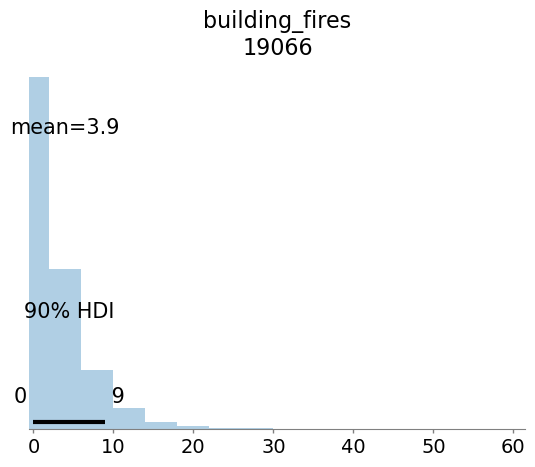

In [55]:
# plot the predictions
az.plot_posterior(posterior_pred, group="predictions", hdi_prob=0.90)